<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/PyTorch_basics%20/basics1-load/Pytorchbasics2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 

import torch.optim as optim


import sys
sys.path.insert(0,'/content')
from idlmam import *

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)
device = torch.device("cuda")

torch.set_printoptions(edgeitems=2, linewidth=75)

<ipython-input-8-ec2b8458856f>:28: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170498071/170498071 [00:01<00:00, 99154712.39it/s] 


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/


In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

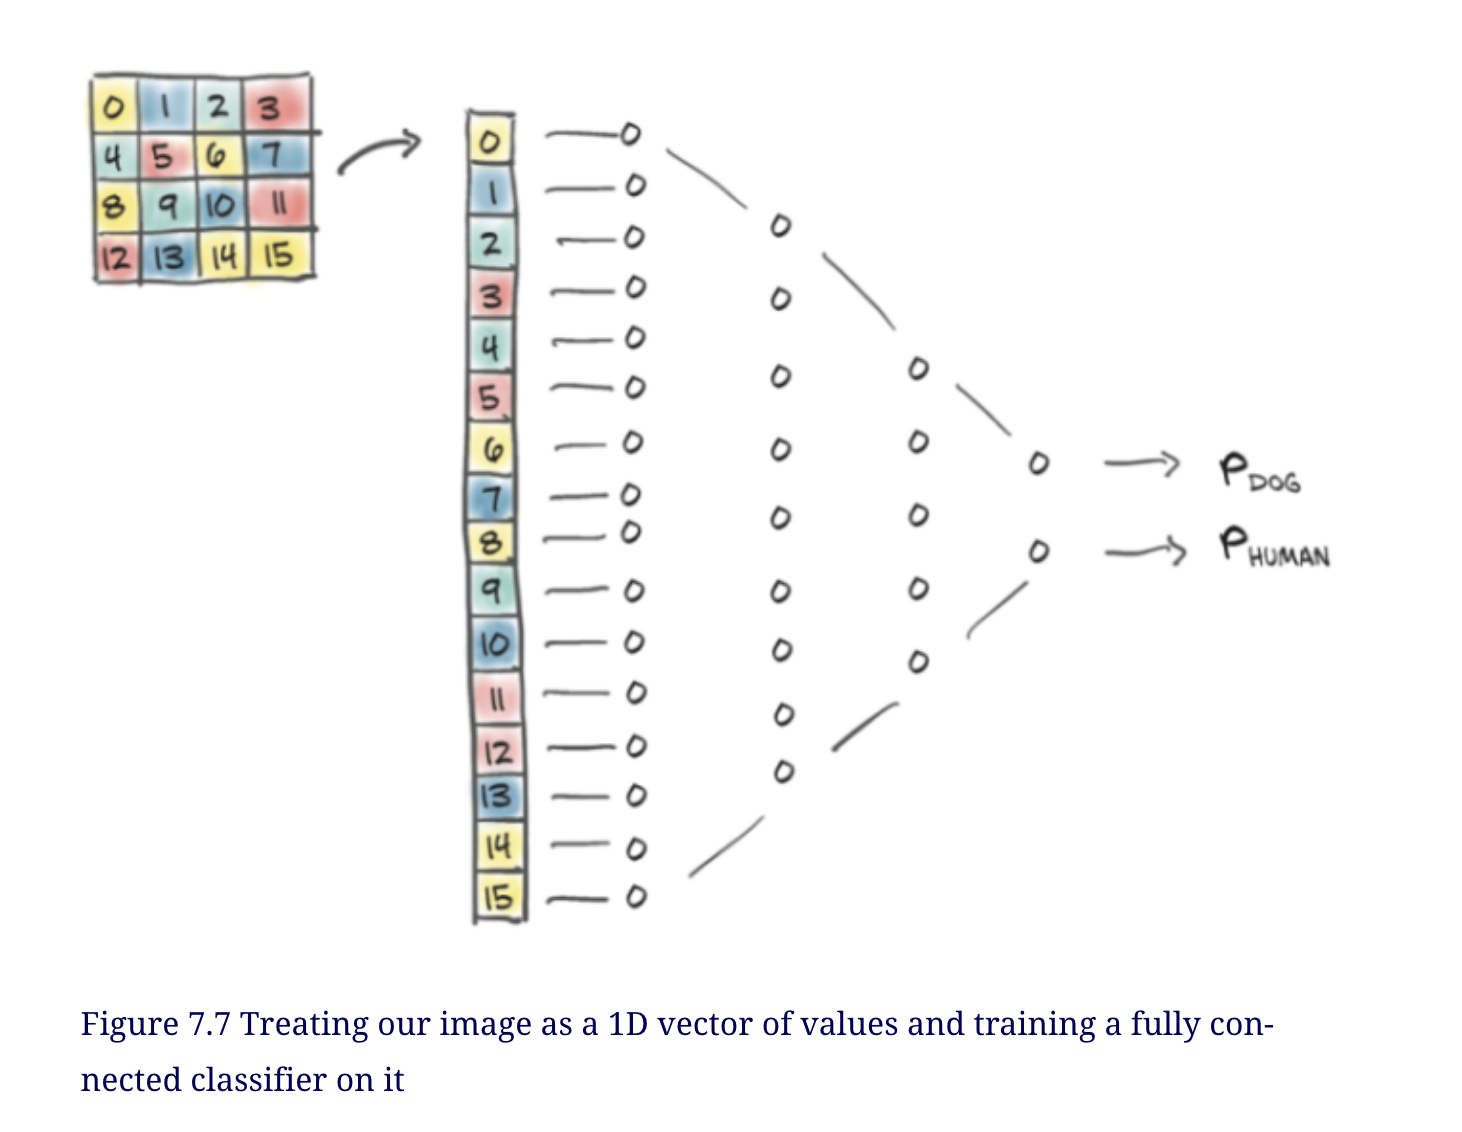

In [10]:
model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(3072, 512)),
            ('tanh', nn.Tanh()),
            ('linear2', nn.Linear(512, 2)),
            ('softmax', nn.Softmax(dim=1))
        ]))


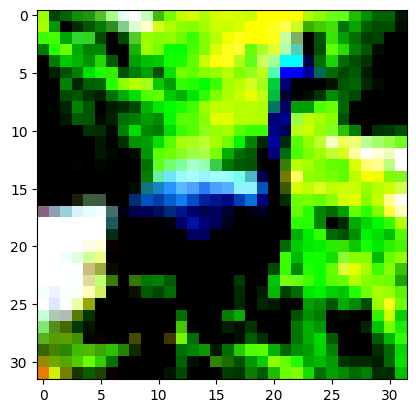

In [11]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

We recall that our model expects 3,072 features in the input, and that nn works with data organized into batches along the zeroth dimension. So we need to turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the zeroth position.

In [12]:
img_batch = img.view(-1).unsqueeze(0)
img_batch

tensor([[ 0.6139, -0.3228,  ..., -1.3182, -1.0484]])

In [13]:
out = model(img_batch)
out

tensor([[0.5141, 0.4859]], grad_fn=<SoftmaxBackward0>)

In our case, we need to take the max along the probability vector (not across batches), therefore, dimension 1:

In [14]:
_, index = torch.max(out, dim=1)

index

tensor([0])

#A loss for classifying

What we need to maximize in this case is the probability associated with the correct class, out[class_index], where out is the output of softmax and class_index is a vector containing 0 for “airplane” and 1 for “bird” for each sample. This quantity--that is, the probability associated with the correct class--is referred to as the likelihood

Summing up, our loss for classification can be computed as follows. For each sample in the batch:

- Run the forward pass, and obtain the output values from the last (linear) layer.

- Compute their softmax, and obtain probabilities.

- Take the predicted probability corresponding to the correct class (the likelihood of the parameters). Note that we know what the correct class is because it’s a supervised problem--it’s our ground truth.

Compute its logarithm, slap a minus sign in front of it, and add it to the loss.



In [16]:
model = nn.Sequential(OrderedDict([
    ('linear1', nn.Linear(3072, 512)),
    ('tanh', nn.Tanh()),
    ('linear2', nn.Linear(512, 2)),
    ('log_softmax', nn.LogSoftmax(dim=1))
]))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in tqdm(range(n_epochs), desc="Epoch"):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 3.566319
Epoch: 1, Loss: 5.207627
Epoch: 2, Loss: 4.413692
Epoch: 3, Loss: 4.501373
Epoch: 4, Loss: 4.102647
Epoch: 5, Loss: 0.284048
Epoch: 6, Loss: 5.355474
Epoch: 7, Loss: 7.614231
Epoch: 8, Loss: 5.758815
Epoch: 9, Loss: 4.781499
Epoch: 10, Loss: 1.437858
Epoch: 11, Loss: 9.105915
Epoch: 12, Loss: 0.196363
Epoch: 13, Loss: 9.431870
Epoch: 14, Loss: 4.752073
Epoch: 15, Loss: 8.312619
Epoch: 16, Loss: 8.786982
Epoch: 17, Loss: 6.989998
Epoch: 18, Loss: 3.764458
Epoch: 19, Loss: 4.560858
Epoch: 20, Loss: 8.612967
Epoch: 21, Loss: 4.551132
Epoch: 22, Loss: 4.845838
Epoch: 23, Loss: 5.098430
Epoch: 24, Loss: 3.586911
Epoch: 25, Loss: 8.004147
Epoch: 26, Loss: 6.006145
Epoch: 27, Loss: 0.093763
Epoch: 28, Loss: 0.719672
Epoch: 29, Loss: 5.440710
Epoch: 30, Loss: 11.280210
Epoch: 31, Loss: 3.307232
Epoch: 32, Loss: 6.086629
Epoch: 33, Loss: 8.972802
Epoch: 34, Loss: 8.824604
Epoch: 35, Loss: 6.173360
Epoch: 36, Loss: 2.856354
Epoch: 37, Loss: 15.420331
Epoch: 38, Loss: 7.1

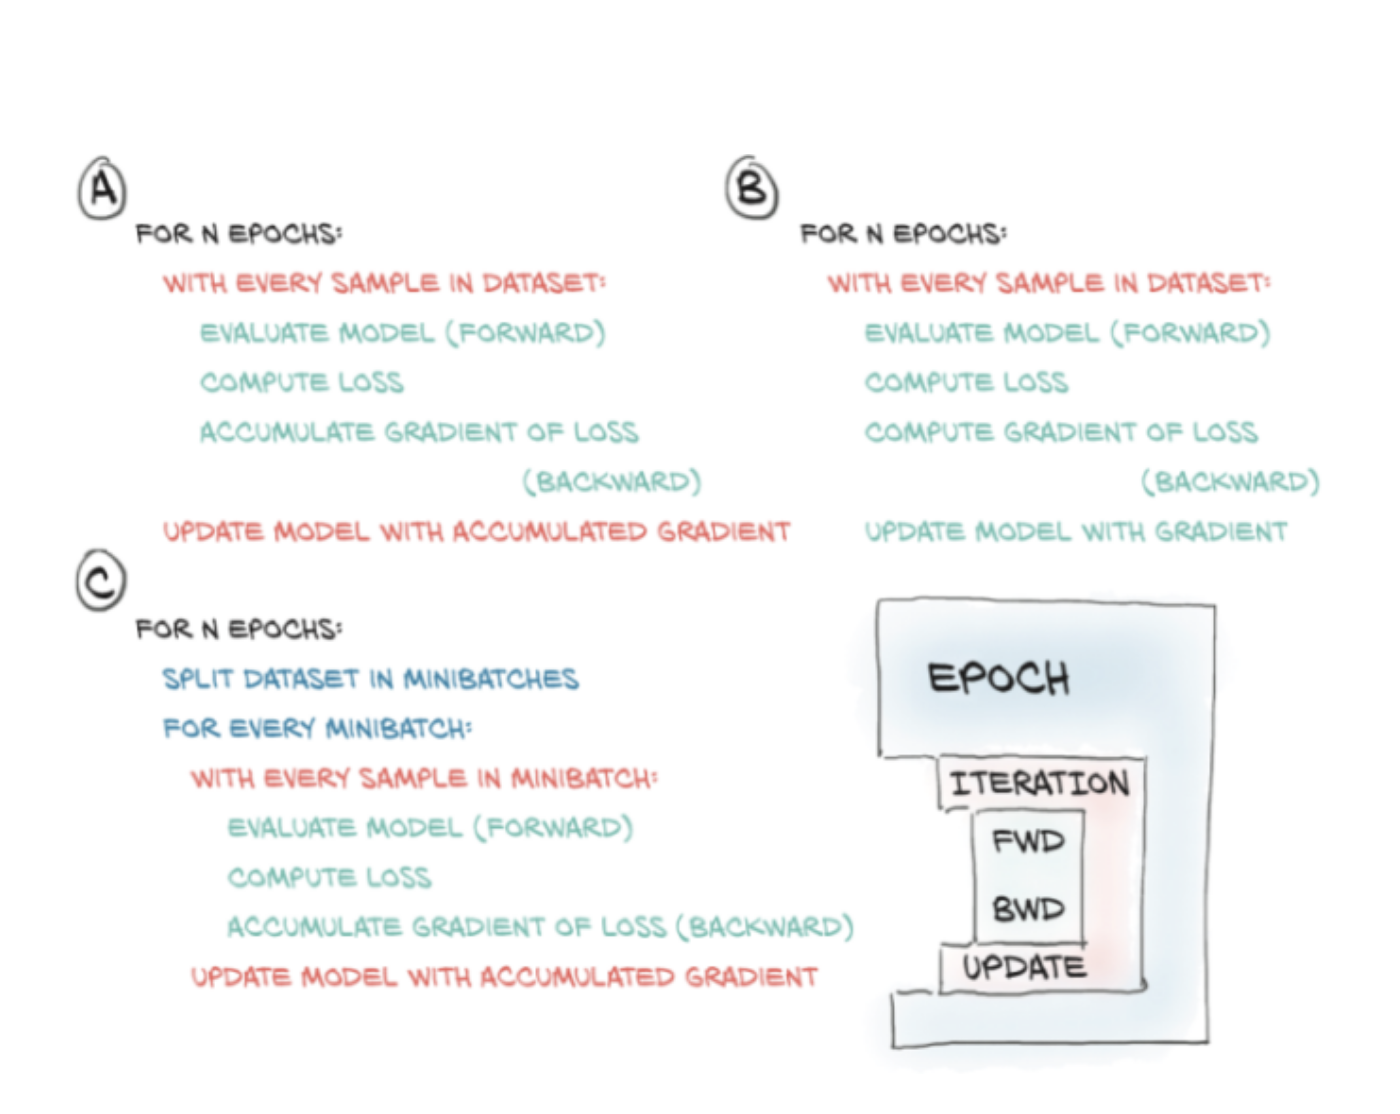

Remember SGD? It stands for stochastic gradient descent, and this is what the S is about: working on small batches (aka minibatches) of shuffled data. It turns out that following gradients estimated over minibatches, which are poorer approximations of gradients estimated across the whole dataset, helps convergence and prevents the optimization process from getting stuck in local minima it encounters along the way.

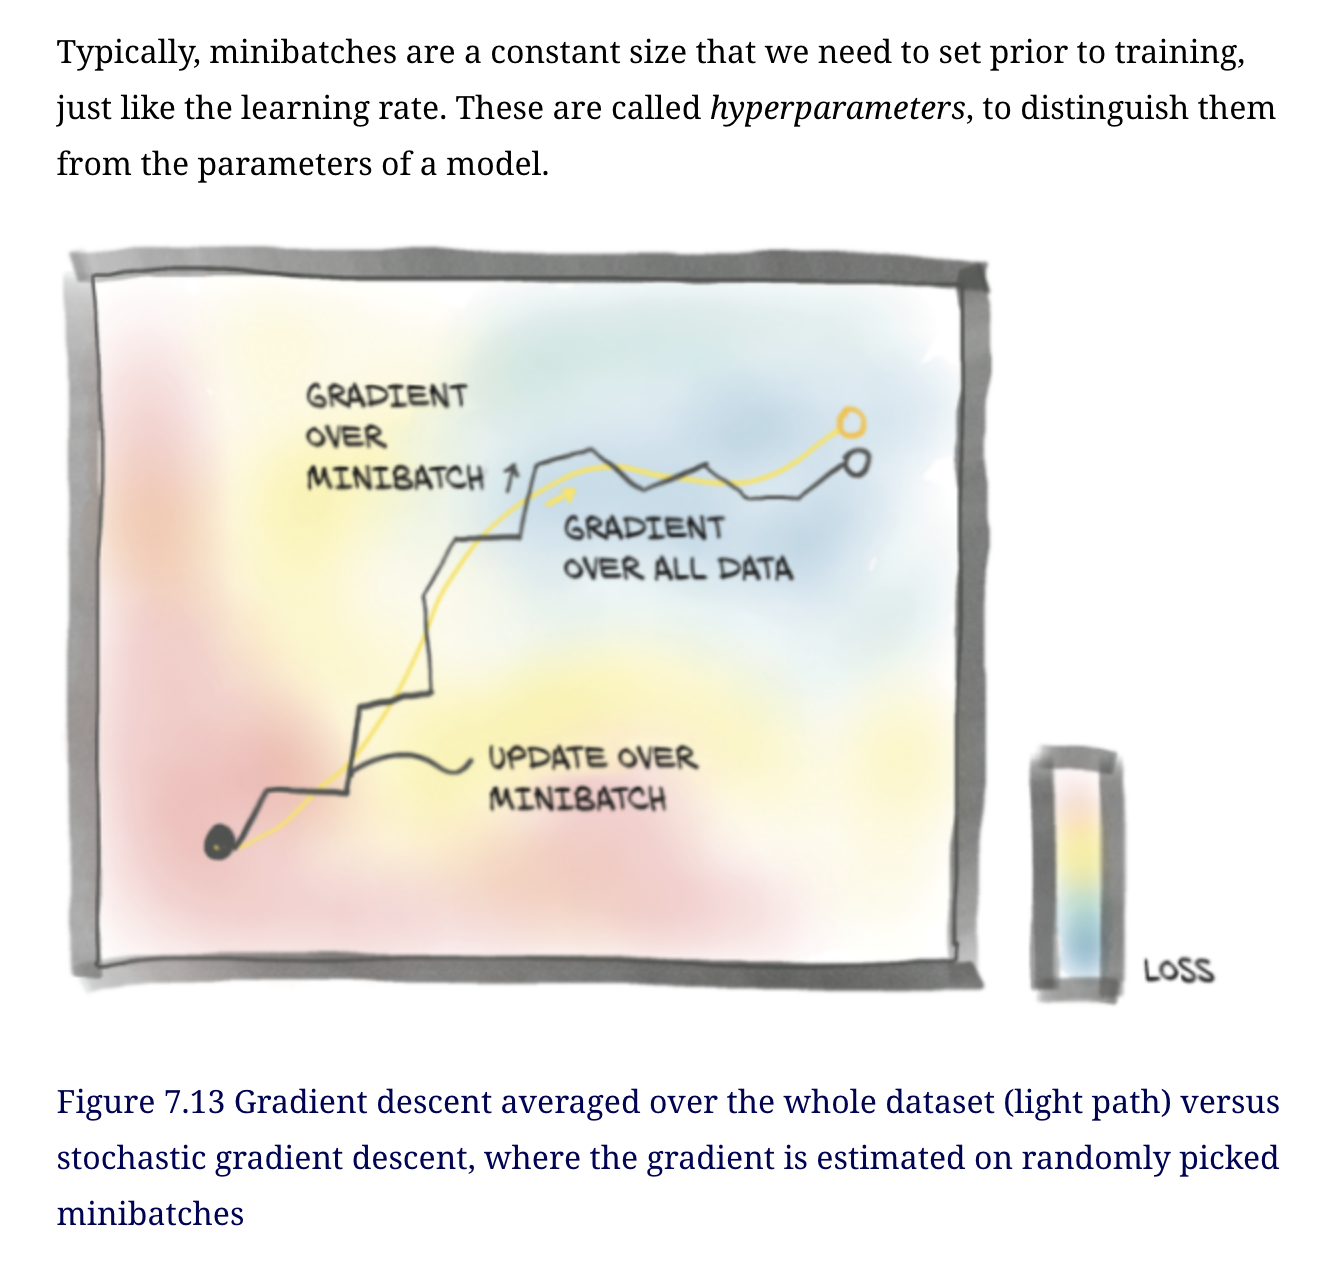

#DATALOADER

In our training code, we chose minibatches of size 1 by picking one item at a time from the dataset. The torch.utils.data module has a class that helps with shuffling and organizing the data in minibatches: DataLoader. The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies. A very common strategy is uniform sampling after shuffling the data at each epoch. 

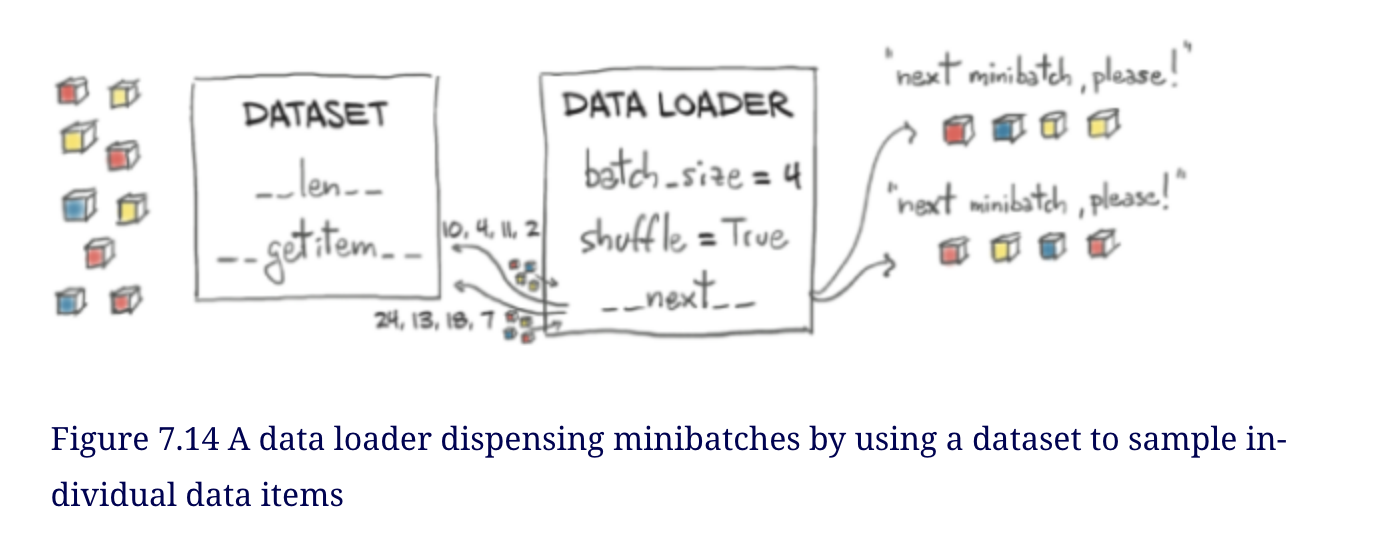

In [17]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)



Training this model and evaluating the accuracy on the validation set (0.802000) lets us appreciate that a larger model bought us an increase in accuracy, but not that much. The accuracy on the training set is practically perfect (0.998100). What is this telling us? That we are overfitting our model in both cases. Our fully connected model is finding a way to discriminate birds and airplanes on the training set by memorizing the training set, but performance on the validation set is not all that great, even if we choose a larger model.

PyTorch offers a quick way to determine how many parameters a model has through the parameters() method of nn.Model (the same method we use to provide the parameters to the optimizer). To find out how many elements are in each tensor instance, we can call the numel method. Summing those gives us our total count. Depending on our use case, counting parameters might require us to check whether a parameter has requires_grad set to True, as well. We might want to differentiate the number of trainable parameters from the overall model size. Let’s take a look at what we have right now:

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in tqdm(range(n_epochs), desc="Epoch"):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.531514
Epoch: 1, Loss: 0.463127
Epoch: 2, Loss: 0.432231
Epoch: 3, Loss: 0.687994
Epoch: 4, Loss: 0.578156
Epoch: 5, Loss: 0.506508
Epoch: 6, Loss: 0.527702
Epoch: 7, Loss: 0.512453
Epoch: 8, Loss: 0.290139
Epoch: 9, Loss: 0.406712
Epoch: 10, Loss: 0.444119
Epoch: 11, Loss: 0.642587
Epoch: 12, Loss: 0.168667
Epoch: 13, Loss: 0.313339
Epoch: 14, Loss: 0.351474
Epoch: 15, Loss: 0.504803
Epoch: 16, Loss: 0.577621
Epoch: 17, Loss: 0.116906
Epoch: 18, Loss: 0.203639
Epoch: 19, Loss: 0.324278
Epoch: 20, Loss: 0.233418
Epoch: 21, Loss: 0.445754
Epoch: 22, Loss: 0.240363
Epoch: 23, Loss: 0.192524
Epoch: 24, Loss: 0.201263
Epoch: 25, Loss: 0.201274
Epoch: 26, Loss: 0.581800
Epoch: 27, Loss: 0.133687
Epoch: 28, Loss: 0.376162
Epoch: 29, Loss: 0.216706
Epoch: 30, Loss: 0.234951
Epoch: 31, Loss: 0.075311
Epoch: 32, Loss: 0.139764
Epoch: 33, Loss: 0.164153
Epoch: 34, Loss: 0.668569
Epoch: 35, Loss: 0.408248
Epoch: 36, Loss: 0.172646
Epoch: 37, Loss: 0.077606
Epoch: 38, Loss: 0.093

In [19]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.998500


In [20]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
 
correct = 0
total = 0
 
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
 
print("Accuracy: %f", correct / total)
 

Accuracy: %f 0.8125


Training this model and evaluating the accuracy on the validation set (0.802000) lets us appreciate that a larger model bought us an increase in accuracy, but not that much. The accuracy on the training set is practically perfect (0.998100). What is this telling us? That we are overfitting our model in both cases. Our fully connected model is finding a way to discriminate birds and airplanes on the training set by memorizing the training set, but performance on the validation set is not all that great, even if we choose a larger model.

PyTorch offers a quick way to determine how many parameters a model has through the parameters() method of nn.Model (the same method we use to provide the parameters to the optimizer). To find out how many elements are in each tensor instance, we can call the numel method. Summing those gives us our total count. Depending on our use case, counting parameters might require us to check whether a parameter has requires_grad set to True, as well. We might want to differentiate the number of trainable parameters from the overall model size. Let’s take a look at what we have right now:

In [21]:
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])